In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

In [2]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)

Common init:         -------------------------- 2023-07-21 21:03:55
dtype:               torch.float32
device:              cpu
contextSize:         3


In [3]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:        -------------------------- 2023-07-21 21:03:55
filePath:            ../../data/names.txt
First few words:     ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:        32033
Vocabulary:          ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:  3.2958


In [4]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:     -------------------------- 2023-07-21 21:03:55
wordShufflingSeed:   42
data dtype:          torch.int64
trRatio:             0.8
devRatio:            0.9
Training:            length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:          length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [5]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:       -------------------------- 2023-07-21 21:03:55
embeddingDims:       10
hiddenLayerSize:     200
learningSeed:        2147483647
Network Structure:  
Layer LinearWithBias 1: [30, 200]; [200]; 
Layer Tanh 2: 
Layer LinearWithBias 3: [200, 27]; [27]; 
Parameters Count:    11897


In [6]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 20_000
log("maxIteration", maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
i = 0
for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)

        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
logLosses()

log("emb.shape", fr.emb.shape)
log("logits.shape", fr.logits.shape)

Learning:            -------------------------- 2023-07-21 21:03:55
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        20000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    20000
  0,      0 losses:     0.0000       3.3085     3.3088     3.3084
  1,   5708 losses:     2.3756       2.3480     2.3453     2.3487
  2,  11416 losses:     2.6205       2.3019     2.3025     2.3036
  3,  17124 losses:     2.1481       2.2747     2.2749     2.2785
Break at max iteration:
 final losses:          2.4249       2.2680     2.2688     2.2712
emb.shape:           [32, 3, 10]
logits.shape:        [32, 27]


In [7]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-21 21:04:00
samplingSeed:        2147483657
maxSampleLength:     50


In [8]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

careah.                93: 12 93 55 29 11 18 189 
amille.               335: 39 30 62 36 33 60 114 
khiemrix.              77: 25 15 55 25 6 3 56 3 88 
thay.                  75: 10 37 118 10 39 
salayane.             119: 16 86 21 35 37 83 50 10 129 
rahnen.                79: 14 83 18 7 39 11 178 
deliah.               147: 14 53 55 41 58 34 225 
jareei.               107: 21 150 21 40 29 1 91 
nellaia.               72: 9 36 55 57 51 16 30 120 
chaiiv.                37: 12 50 108 10 2 3 33 
kaleig.               208: 25 114 28 49 35 60 34 
dham.                  65: 14 5 102 7 43 
jori.                 207: 21 41 45 71 58 
qus.                   14: 1 123 36 137 
tharlin.               91: 10 37 118 35 13 67 75 139 
alian.                443: 39 39 56 44 106 127 
quw.                    8: 1 123 5 150 
jelon.                179: 21 30 42 10 122 147 
jaryni.               124: 21 150 21 13 26 9 108 
jace.                 189: 21 150 9 53 67 


In [9]:
def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    1      : 0 
m.                   9      : 22 0 
mi.                  35     : 22 37 0 
mic.                 114    : 22 37 20 11 
mich.                196    : 22 37 20 53 124 
micha.               152    : 22 37 20 53 68 27 
michal.              133    : 22 37 20 53 68 25 20 
michael.             132    : 22 37 20 53 68 4 91 57 
michaela.            131    : 22 37 20 53 68 4 91 33 72 
michaella.           146    : 22 37 20 53 68 4 91 44 51 139 
michel.              146    : 22 37 20 53 22 65 49 
michalx.             65     : 22 37 20 53 68 25 0 26 
michalxx.            47     : 22 37 20 53 68 25 0 0 90 
michalxxx.           28     : 22 37 20 53 68 25 0 0 0 50 
martin.              217    : 22 154 67 6 51 77 183 
andrej.              168    : 39 33 33 15 74 1 92 
andrey.              269    : 39 33 33 15 74 30 92 
joey.                91     : 21 41 11 2 138 
james.               126    : 21 150 20 41 5 44 
xin.                 13     : 1 36 43 129 
maxim.         

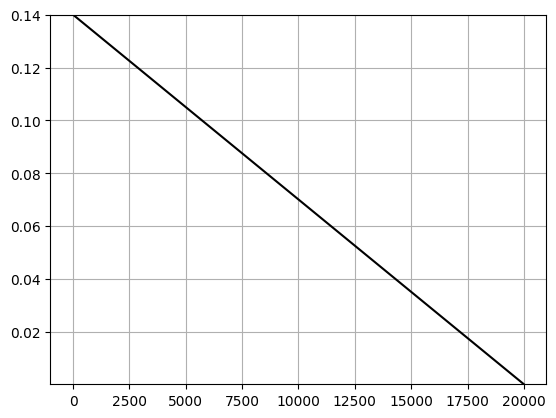

Actual min max LR 0.14 0.00010699499999999862


In [10]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

AttributeError: 'ForwardPassResult' object has no attribute 'h'

<Figure size 2000x1000 with 0 Axes>

In [30]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    #ax.plot(lrAtIx, lossAtIx)
    plt.show()

In [31]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    ax.plot(stepIx, lossAtIx)
    plt.show()

In [32]:
if newNet:
    pass
else:
    fig, ax = plt.subplots()
    fig.set_facecolor("#777777")
    ax.set_facecolor("#222222")
    ax.plot(stepIx, logLossAtIx)
    plt.show()

In [33]:
if newNet:
    pass
else:
    dim = 0
    fig = plt.figure(figsize=(8,8))
    fig.set_facecolor("#777777")
    sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
    for i in range(np.C.shape[0]):
        plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
    plt.grid()

In [34]:
#np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

In [35]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
